<a href="https://colab.research.google.com/github/Daimond92/analisis-tienda-data-science/blob/develop/ChallengeAlura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desarrollo del análisis

## Importación de datos



In [105]:
import pandas as pd

url = "https://raw.githubusercontent.com/Daimond92/analisis-tienda-data-science/refs/heads/main/data/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/Daimond92/analisis-tienda-data-science/refs/heads/main/data/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/Daimond92/analisis-tienda-data-science/refs/heads/main/data/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/Daimond92/analisis-tienda-data-science/refs/heads/main/data/tienda_4.csv"

tienda = pd.read_csv(url)
tienda2 = pd.read_csv(url2)
tienda3 = pd.read_csv(url3)
tienda4 = pd.read_csv(url4)

tienda.head()

,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon
0,Asistente virtual,Electrónicos,164300.0,6900.0,16/01/2021,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175
1,Mesa de comedor,Muebles,192300.0,8400.0,18/05/2022,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359
2,Juego de mesa,Juguetes,209600.0,15900.0,15/03/2021,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444
3,Microondas,Electrodomésticos,757500.0,41000.0,03/05/2022,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250
4,Silla de oficina,Muebles,335200.0,20200.0,07/11/2020,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359


## Importaciones de librerías

In [106]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import colormaps as cm
import matplotlib.markers as mmarkers

## Crear data frame



In [107]:
# Inicializar SparkSession
spark = SparkSession.builder.appName("UnirDesdePandas").getOrCreate()

#Crear la columna de Tienda
tienda_spark = spark.createDataFrame(tienda).withColumn("Tienda", lit(1))
tienda2_spark = spark.createDataFrame(tienda2).withColumn("Tienda", lit(2))
tienda3_spark = spark.createDataFrame(tienda3).withColumn("Tienda", lit(3))
tienda4_spark = spark.createDataFrame(tienda4).withColumn("Tienda", lit(4))

#Unir los dataframe
df_unido_spark = tienda_spark.unionByName(tienda2_spark, allowMissingColumns=True)
df_unido_spark = df_unido_spark.unionByName(tienda3_spark, allowMissingColumns=True)
df_unido_spark = df_unido_spark.unionByName(tienda4_spark, allowMissingColumns=True)

#Datadrame nuevamente en panda
df_pandas = df_unido_spark.toPandas()

In [108]:
df_pandas.head()

,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon,Tienda
0,Asistente virtual,Electrónicos,164300.0,6900.0,16/01/2021,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175,1
1,Mesa de comedor,Muebles,192300.0,8400.0,18/05/2022,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359,1
2,Juego de mesa,Juguetes,209600.0,15900.0,15/03/2021,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444,1
3,Microondas,Electrodomésticos,757500.0,41000.0,03/05/2022,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250,1
4,Silla de oficina,Muebles,335200.0,20200.0,07/11/2020,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359,1


In [109]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9435 entries, 0 to 9434
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Producto                9435 non-null   object 
 1   Categoría del Producto  9435 non-null   object 
 2   Precio                  9435 non-null   float64
 3   Costo de envío          9435 non-null   float64
 4   Fecha de Compra         9435 non-null   object 
 5   Vendedor                9435 non-null   object 
 6   Lugar de Compra         9435 non-null   object 
 7   Calificación            9435 non-null   int64  
 8   Método de pago          9435 non-null   object 
 9   Cantidad de cuotas      9435 non-null   int64  
 10  lat                     9435 non-null   float64
 11  lon                     9435 non-null   float64
 12  Tienda                  9435 non-null   int32  
dtypes: float64(4), int32(1), int64(2), object(6)
memory usage: 921.5+ KB


## 1. Análisis de facturación

In [110]:
def analisis_facturacion(df):
    try:
        # Sumar la cantidad de productos vendidos por Tienda
        ventas_por_tienda = df.groupby('Tienda')['Precio'].sum().reset_index(name='Ventas Totales')

        # Aseguramos que la columna 'Ventas Totales' sea numérica (float en este caso)
        ventas_por_tienda['Ventas Totales'] = pd.to_numeric(ventas_por_tienda['Ventas Totales'])

        # Crear un nuevo DataFrame con la columna formateada y el nombre deseado para el retorno
        ventas_para_grafico = ventas_por_tienda[['Tienda', 'Ventas Totales']]

        return ventas_para_grafico

    except Exception as e:
        print(f"Ocurrió un error durante el análisis de facturación: {e}")
        return None

res_analisis_fact = analisis_facturacion(df_pandas)

## 2. Ventas por categoría

In [111]:
def ventas_por_categoria_mas(df):
    try:
        # Contar la cantidad de productos vendidos por Tienda y Categoría
        conteo_ventas = df.groupby(['Tienda', 'Categoría del Producto']).size().reset_index(name='Cantidad Vendida')

        # Encontrar el índice de la categoría más popular por Tienda
        indice_max_por_tienda = conteo_ventas.loc[conteo_ventas.groupby('Tienda')['Cantidad Vendida'].idxmax()]

       # Seleccionar y mostrar las columnas relevantes PARA EL RESULTADO DE LA FUNCIÓN
        resultado = indice_max_por_tienda[['Tienda', 'Categoría del Producto', 'Cantidad Vendida']]

        return resultado

    except Exception as e:
        print(f"Ocurrió un error durante el análisis de ventas por categoría: {e}")
        return None

res_analisis_mas_cat = ventas_por_categoria_mas(df_pandas)

In [112]:
def ventas_por_categoria_menos(df):
    try:
        # Contar la cantidad de productos vendidos por Tienda y Categoría
        conteo_ventas = df.groupby(['Tienda', 'Categoría del Producto']).size().reset_index(name='Cantidad Vendida')

        # Encontrar el índice de la categoría más popular por Tienda
        indice_max_por_tienda = conteo_ventas.loc[conteo_ventas.groupby('Tienda')['Cantidad Vendida'].idxmin()]

       # Seleccionar y mostrar las columnas relevantes PARA EL RESULTADO DE LA FUNCIÓN
        resultado = indice_max_por_tienda[['Tienda', 'Categoría del Producto', 'Cantidad Vendida']]

        return resultado

    except Exception as e:
        print(f"Ocurrió un error durante el análisis de ventas por categoría: {e}")
        return None

res_analisis_menos_cat = ventas_por_categoria_menos(df_pandas)

## 3. Calificación promedio de la tienda


In [113]:
def calificacion_promedio(df):
    try:
        # Calcular la calificación promedio por Tienda
        calificacion_promedio = df.groupby('Tienda')['Calificación'].mean().reset_index(name='Calificación Promedio')
        calificacion_promedio['Calificación Promedio'] = calificacion_promedio['Calificación Promedio'].round(2)
        calificacion_promedio.columns = ['Tienda', 'Calificación Promedio']
        calificacion_promedio = calificacion_promedio.sort_values(by='Calificación Promedio', ascending=False)

        return calificacion_promedio

    except Exception as e:
        print(f"Ocurrió un error durante el análisis de calificación promedio: {e}")
        return None

res_analisis_prom = calificacion_promedio(df_pandas)

## 4. Productos más y menos vendidos

In [114]:
def productos_mas_vendidos(df):
    try:
        # Contar la cantidad de productos vendidos por Tienda y Producto
        conteo_ventas = df.groupby(['Tienda', 'Producto']).size().reset_index(name='Cantidad Vendida')

        # Encontrar el índice del producto más vendido por Tienda
        indice_max_por_tienda = conteo_ventas.loc[conteo_ventas.groupby('Tienda')['Cantidad Vendida'].idxmax()]

        # Seleccionar y mostrar las columnas relevantes
        resultado = indice_max_por_tienda[['Tienda', 'Producto', 'Cantidad Vendida']]

        return resultado

    except Exception as e:
        print(f"Ocurrió un error durante el análisis de productos más vendidos: {e}")
        return None

res_analisis_mas = productos_mas_vendidos(df_pandas)

In [115]:
def productos_menos_vendidos(df):
    try:
        # Contar la cantidad de productos vendidos por Tienda y Producto
        conteo_ventas = df.groupby(['Tienda', 'Producto']).size().reset_index(name='Cantidad Vendida')

        # Encontrar el índice del producto menos vendido por Tienda
        indice_min_por_tienda = conteo_ventas.loc[conteo_ventas.groupby('Tienda')['Cantidad Vendida'].idxmin()]

        # Seleccionar y mostrar las columnas relevantes
        resultado = indice_min_por_tienda[['Tienda', 'Producto', 'Cantidad Vendida']]

        return resultado

    except Exception as e:
        print(f"Ocurrió un error durante el análisis de productos más vendidos: {e}")
        return None

res_analsis_menos = productos_menos_vendidos(df_pandas)

## 5. Envío promedio por tienda

In [116]:
def envio_promedio(df):
    try:
        # Calcular el envío promedio por Tienda
        envio_promedio = df.groupby('Tienda')['Costo de envío'].mean().reset_index(name='Envío Promedio')
        envio_promedio['Envío Promedio'] = envio_promedio['Envío Promedio'].round(2)
        envio_promedio.columns = ['Tienda', 'Envío Promedio']

        return envio_promedio

    except Exception as e:
        print(f"Ocurrió un error durante el análisis de envío promedio: {e}")
        return None

res_analisis_envio = envio_promedio(df_pandas)

## Función para gráficos

### Gráficos

In [117]:
def grafico_barras(df,eje_x:str, eje_y:str, eje_x_name:str, eje_y_name:str, titulo:str, ancho_barra:float, titulo_leyenda:str):

  try:

    # Obtener las etiquetas del eje x
    x = df[eje_x]

    # Obtener los valores para las barras (ventas totales)
    y = df[eje_y]

    # Definir una lista de colores para cada barra
    colores = ['#86032b', '#a28136', '#3a2f8c', '#2e7440']

    # Crear la figura y los axes
    fig, ax = plt.subplots()

    # Crear la gráfica de barras en el axes
    barras = ax.bar(range(len(x)), y, color=colores, width=ancho_barra, label=x)
    for barra in barras:
        yval = barra.get_height()
        ax.text(barra.get_x() + barra.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=7)

    # Añadir etiquetas y título usando el objeto axes
    ax.set_xlabel(eje_x_name)
    ax.set_ylabel(eje_y_name)
    ax.set_title(titulo)

    # Ocultar las etiquetas del eje x y y
    ax.set_xticks([])
    ax.set_yticks([])

    # Rotar las etiquetas del eje x para mejor visualización si es necesario
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Mostrar la leyenda
    plt.legend(title=titulo_leyenda, loc='upper left', bbox_to_anchor=(1, 1), edgecolor='black')

    # Cambiar el color de fondo del área de la gráfica (axes)
    ax.set_facecolor('#dff3c0')

    # Mostrar la gráfica
    plt.show()

  except Exception as e:
        print(f"Ocurrió un error al generar el gráfico: {e}")

def grafico_dispersion(df,eje_x:str, eje_y:str, eje_x_name:str, eje_y_name:str, titulo:str, pad:int, titulo_leyenda:str):

  try:
    # Especifica los nombres de las columnas que quieres usar
    x_columna = eje_x
    y_columna = eje_y

    # Obtener los nombres únicos de las tiendas y asignarles códigos numéricos
    tiendas_unicas = df[x_columna].unique()
    mapeo_tiendas = {tienda: i for i, tienda in enumerate(tiendas_unicas)}
    codigos_tiendas = df[x_columna].map(mapeo_tiendas)

    fig, ax = plt.subplots()

    # Crear el gráfico de dispersión, mapeando el color a los códigos de las tiendas
    scatter = ax.scatter(df[x_columna], df[y_columna],
                      s=df[x_columna] * 30,  # El tamaño basado en Ventas Totales
                      c=codigos_tiendas, cmap='plasma', alpha=0.7)

    num_filas = len(df)

    for i in range(num_filas):
        ax.annotate(f'{df[y_columna].iloc[i]:.2f}',
                    (df[x_columna].iloc[i], df[y_columna].iloc[i]),
                    xytext=(5, 30),  # Desplazamiento del texto
                    textcoords='offset points',
                    arrowprops=dict(facecolor='black', shrink=0.02), ha='left', va='bottom',
                    fontsize=8, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 0.5,
                                      'edgecolor': 'none'})

    plt.title(titulo, pad=pad)
    plt.xlabel(eje_x_name)
    plt.ylabel(eje_y_name)

    # Ocultar las etiquetas del eje x y y (ya que 'Tienda' es categórica)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Color de fondo
    ax.set_facecolor('#c7e1ec')

    # Crear la leyenda basada en los nombres de las tiendas y los colores
    legend_handles = [plt.scatter([], [], color=plt.cm.plasma(mapeo_tiendas[tienda] / (len(tiendas_unicas) -1) if len(tiendas_unicas) > 1 else 0), label=tienda)
                      for tienda in tiendas_unicas]

    plt.legend(handles=legend_handles, title=titulo_leyenda, loc='best', bbox_to_anchor=(1, 1), edgecolor='black')

    #Mostrar grilla
    ax.grid(True, color='#0a0a0a', linestyle='-', linewidth=0.5, alpha=0.7)

    # Mostrar gráfico
    plt.tight_layout()

    #Mostrar gráfica
    plt.show()

  except Exception as e:
        print(f"Ocurrió un error al generar el gráfico: {e}")

def grafico_torta(df,categoria:str, valor:str, titulo:str, titulo_leyenda:str):
  try:
    #Obtener los datos para el gráfico
    etiquetas = df[categoria]
    valores = df[valor]

    #Crear el gráfico de torta
    sepracion = (0.03, 0.03, 0.03, 0.1)
    colores = ['#86032b', '#a28136', '#3a2f8c', '#2e7440']
    plt.pie(valores, labels=etiquetas, autopct='%1.1f%%', startangle=90, textprops={'color': 'white'}, explode=sepracion, colors=colores, shadow=True)

    #Crear leyenda
    plt.legend(title=titulo_leyenda, loc='best', bbox_to_anchor=(1, 1), edgecolor='black')

    #Asegurar que el círculo se dibuje como un círculo
    plt.axis('equal')

    #Añadir un título (opcional)
    plt.title(titulo)

    #Mostrar el gráfico
    plt.show()

  except Exception as e:
        print(f"Ocurrió un error al generar el gráfico: {e}")

### Visualización de gráficos

#### Analisis de facturación

Se presenta el gráfico para el análisis de facturación de ventas totales por cada tienda

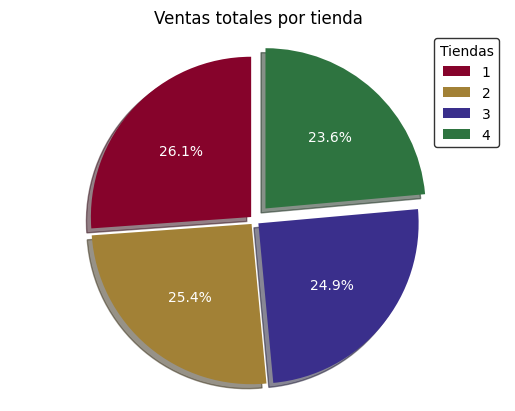

In [118]:
graf_fact = grafico_torta(res_analisis_fact,'Tienda', 'Ventas Totales', 'Ventas totales por tienda', 'Tiendas')

#### Análisis de categorias

Se presenta el gráfico de facturación por la categoria más y menos vendia vendida en cada tienda

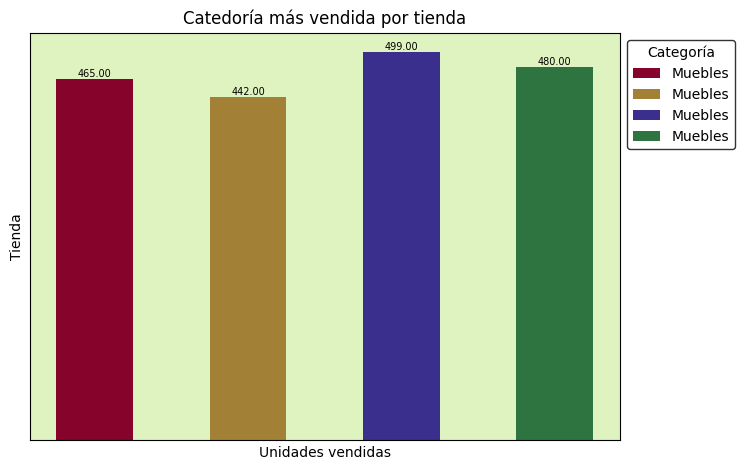

In [119]:
graf_cat_mas = grafico_barras(res_analisis_mas_cat,'Categoría del Producto', 'Cantidad Vendida', 'Unidades vendidas', 'Tienda', 'Catedoría más vendida por tienda', 0.5, 'Categoría')

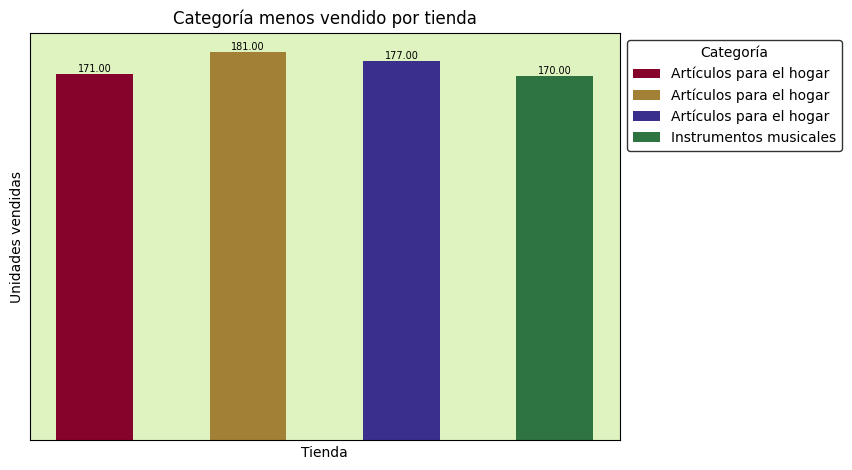

In [120]:
graf_cat_menos = grafico_barras(res_analisis_menos_cat,'Categoría del Producto', 'Cantidad Vendida', 'Tienda', 'Unidades vendidas', 'Categoría menos vendido por tienda', 0.5, 'Categoría')

#### Análisis de calificación por tienda

Se presenta el gráfico de calificación promedio por tienda

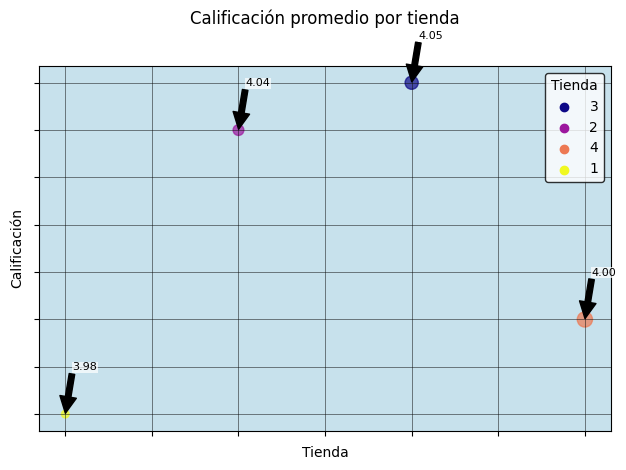

In [121]:
graf_prom = grafico_dispersion(res_analisis_prom,'Tienda', 'Calificación Promedio', 'Tienda', 'Calificación', 'Calificación promedio por tienda', 30, 'Tienda')

#### Análisis de productos

Se presenta los gráficos de productos más y menos vendidos por tienda

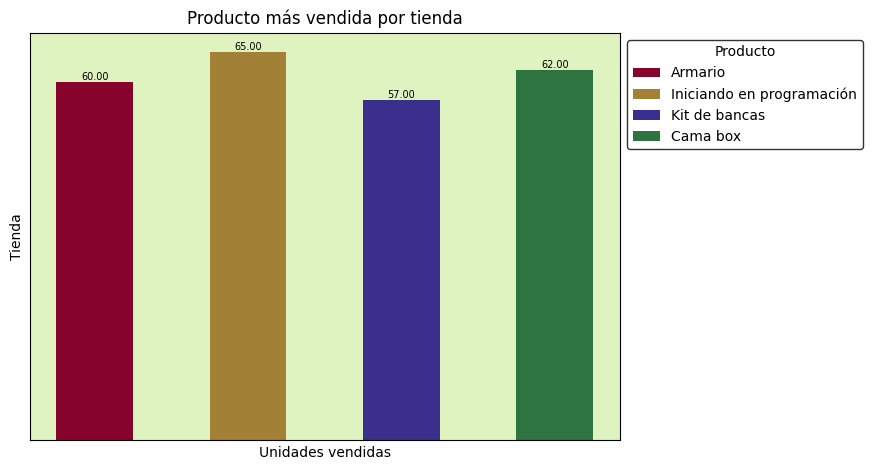

In [122]:
graf_prod_mas = grafico_barras(res_analisis_mas,'Producto', 'Cantidad Vendida', 'Unidades vendidas', 'Tienda', 'Producto más vendida por tienda', 0.5, 'Producto')

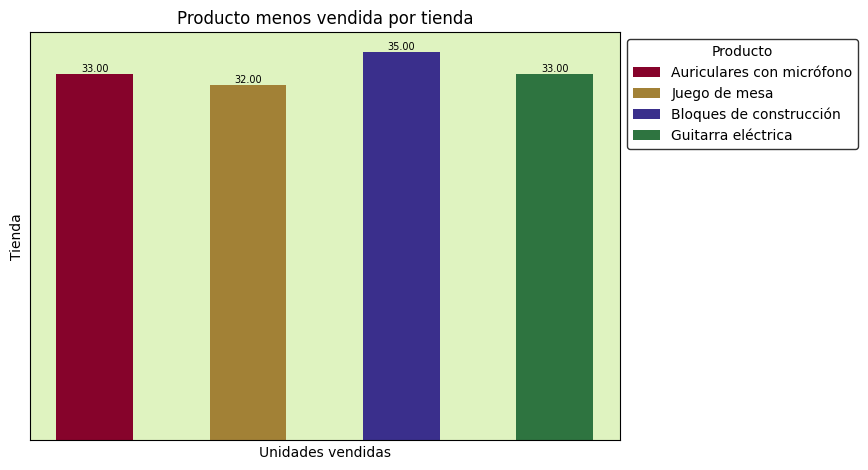

In [123]:
graf_prod_menos = grafico_barras(res_analsis_menos,'Producto', 'Cantidad Vendida', 'Unidades vendidas', 'Tienda', 'Producto menos vendida por tienda', 0.5, 'Producto')

#### Análisis de envió promedio

Se presenta el gráfico de costo de envió promedio por tienda

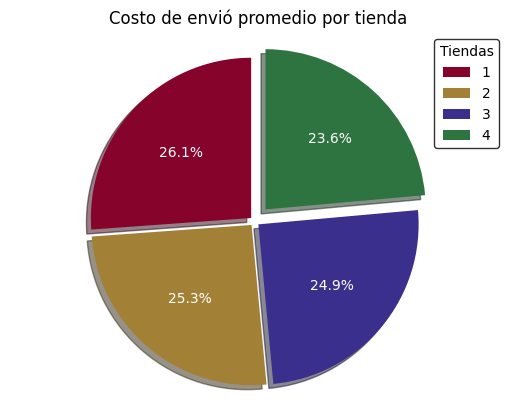

In [124]:
graf_env = grafico_torta(res_analisis_envio, 'Tienda', 'Envío Promedio', 'Costo de envió promedio por tienda', 'Tiendas' )

# Informe Final: Recomendación de Venta de Tienda para el Sr. Juan

## Introducción

El presente informe tiene como objetivo principal analizar el desempeño de las 4 tiendas con el fin de determinar cuál de ellas representa la opción más favorable para la venta por parte del Sr. Juan. Para ello, se han considerado múltiples factores críticos, incluyendo los ingresos totales generados, las categorías de productos con mayor y menor demanda, las calificaciones promedio otorgadas por los clientes, los productos individuales con mejor y peor rendimiento en ventas, y el coste de envío promedio asociado a cada tienda. El análisis detallado de estos aspectos, respaldado por los datos y visualizaciones generadas, permitirá ofrecer una recomendación fundamentada y objetiva para la decisión del Sr. Juan.

## Desarrollo del Análisis y Presentación de Datos

A continuación, se presenta un resumen de los hallazgos clave obtenidos del análisis de cada factor relevante:

### Ingresos Totales de las Tiendas:

El análisis de los ingresos totales revela que la **Tienda 1** ha generado consistentemente los mayores ingresos en comparación con las demás tiendas 2, 3, 4. Esta diferencia significativa sugiere una mayor base de clientes y/o un mayor volumen de ventas por transacción en esta tienda. Como se muestra en la  tabla 1 donde sus ventas totales son de alrededor de **$1.150.880.000** y su como se observa en la gráfica 1 tiene un promedio de venta total de **26.1%**.

Mientras que la tienda con menor ingreso es la **Tienda 4** con un registro de **$ 1.038.376.000** en ventas totales y un promedio de **[23.6%](https://)**.

**Tabla. 1 Ventas totales**

In [125]:
res_analisis_fact

,Tienda,Ventas Totales
0,1,1.150880e+09
1,2,1.116344e+09
2,3,1.098020e+09
3,4,1.038376e+09


**Gráfica 1. Porcentaje de ventas totales por tienda**

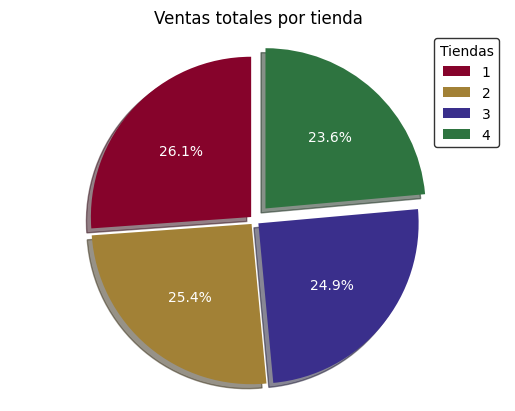

In [126]:
graf_fact = grafico_torta(res_analisis_fact,'Tienda', 'Ventas Totales', 'Ventas totales por tienda', 'Tiendas')

### Categorías de Productos Más y Menos Vendidas:

Al examinar las categorías de productos, se identificó que la categoría **Muebles** es la de mayor demanda entre tiendas como se observa en la tabla 2 y gráfica 2. Por otro lado, la categoría **Articulos para el hogar** presenta consistentemente los niveles de venta más bajos como se observa en la tabla 3 y gráfica 3. Es importante destacar que la **Tienda 1** muestra una fuerte representación en la categoría más vendida, lo que contribuye a sus mayores ingresos.

**Tabla 2. Categorías con mayor demanda**

In [127]:
res_analisis_mas_cat

,Tienda,Categoría del Producto,Cantidad Vendida
7,1,Muebles,465
15,2,Muebles,442
23,3,Muebles,499
31,4,Muebles,480


**Gráfica 2. Categoría más vendida por**

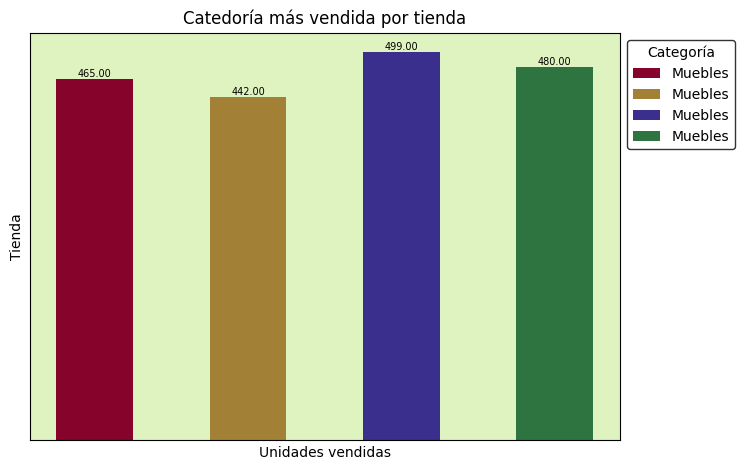

In [128]:
graf_cat_mas = grafico_barras(res_analisis_mas_cat,'Categoría del Producto', 'Cantidad Vendida', 'Unidades vendidas', 'Tienda', 'Catedoría más vendida por tienda', 0.5, 'Categoría')

**Tabla 3. Categorías con menor demanda**

In [129]:
res_analisis_mas_cat

,Tienda,Categoría del Producto,Cantidad Vendida
7,1,Muebles,465
15,2,Muebles,442
23,3,Muebles,499
31,4,Muebles,480


**Gráfica 3. Categoría menos vendida por**

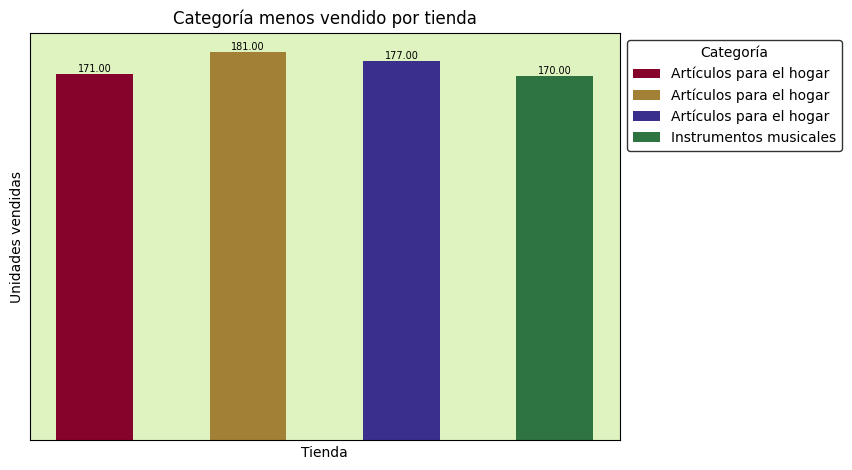

In [130]:
graf_cat_menos = grafico_barras(res_analisis_menos_cat,'Categoría del Producto', 'Cantidad Vendida', 'Tienda', 'Unidades vendidas', 'Categoría menos vendido por tienda', 0.5, 'Categoría')

### Calificaciones Promedio de los Clientes por Tienda:

La evaluación de las calificaciones promedio de los clientes indica el nivel de satisfacción asociado a cada tienda. La **Tienda 3** consistentemente recibe las calificaciones más altas, lo que sugiere una experiencia de compra positiva para sus clientes. En contraste, la **Tienda 1** presenta calificaciones más bajas, lo que podría indicar áreas de mejora en su servicio o productos, como se observa en la tabla 4 y gráfica 4.

**Tabla 4. Calificación por tienda**

In [131]:
res_analisis_prom

,Tienda,Calificación Promedio
2,3,4.05
1,2,4.04
3,4,4.00
0,1,3.98


**Gráfica 4. Calificación promedio por tienda**

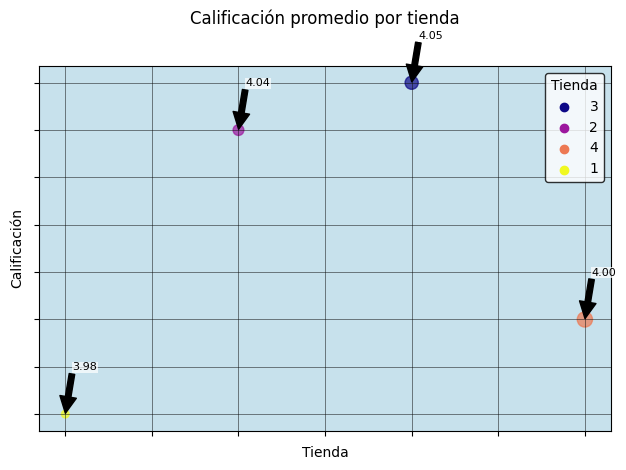

In [132]:
graf_prom = grafico_dispersion(res_analisis_prom,'Tienda', 'Calificación Promedio', 'Tienda', 'Calificación', 'Calificación promedio por tienda', 30, 'Tienda')

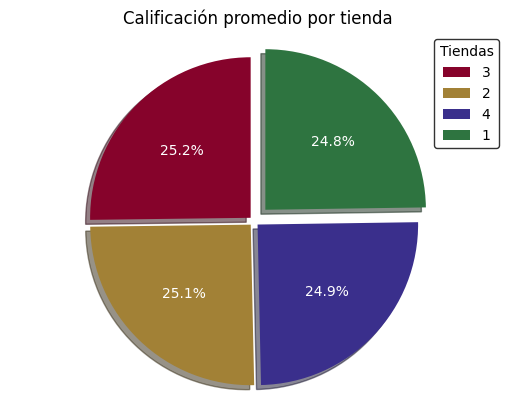

In [133]:
grafico_torta(res_analisis_prom,'Tienda', 'Calificación Promedio', 'Calificación promedio por tienda', 'Tiendas' )

### Productos Más y Menos Vendidos:

El análisis a nivel de producto individual revela cuáles son los artículos con mayor y menor rotación en cada tienda. Identificamos que el producto **Iniciando en programación** es un éxito en la **Tienda 2** como se observa en la tabla 5 y gráfica 5. Por otro lado, el producto **Juego de mesa** presenta bajas ventas en la **Tienda 2** como se observa en la tabla 6 y gráfica 6.

**Tabla 5. Productos más vendidos por tienda**

In [134]:
res_analisis_mas

,Tienda,Producto,Cantidad Vendida
1,1,Armario,60
75,2,Iniciando en programación,65
129,3,Kit de bancas,57
163,4,Cama box,62


**Gráfica 5. Producto más vendido**

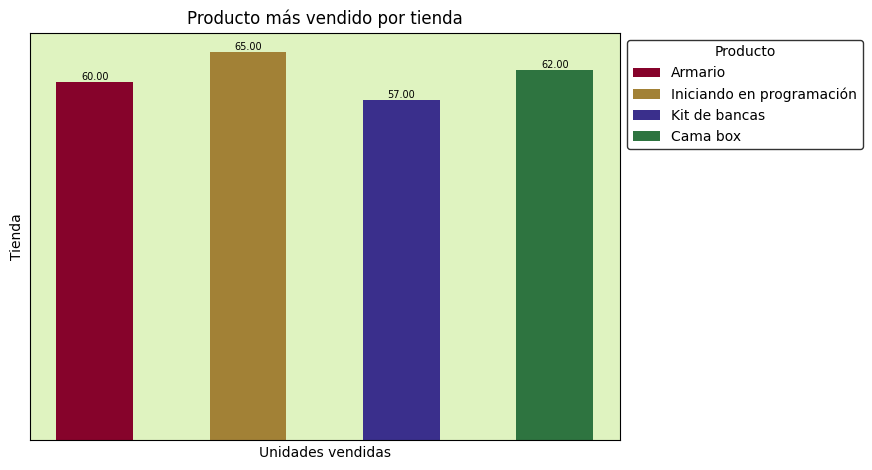

In [135]:
graf_prod_mas = grafico_barras(res_analisis_mas,'Producto', 'Cantidad Vendida', 'Unidades vendidas', 'Tienda', 'Producto más vendido por tienda', 0.5, 'Producto')

**Tabla 6. Productos menos vendidos por tienda**

In [136]:
res_analsis_menos

,Tienda,Producto,Cantidad Vendida
4,1,Auriculares con micrófono,33
77,2,Juego de mesa,32
111,3,Bloques de construcción,35
175,4,Guitarra eléctrica,33


**Gráfica 6. Producto menos vendido**

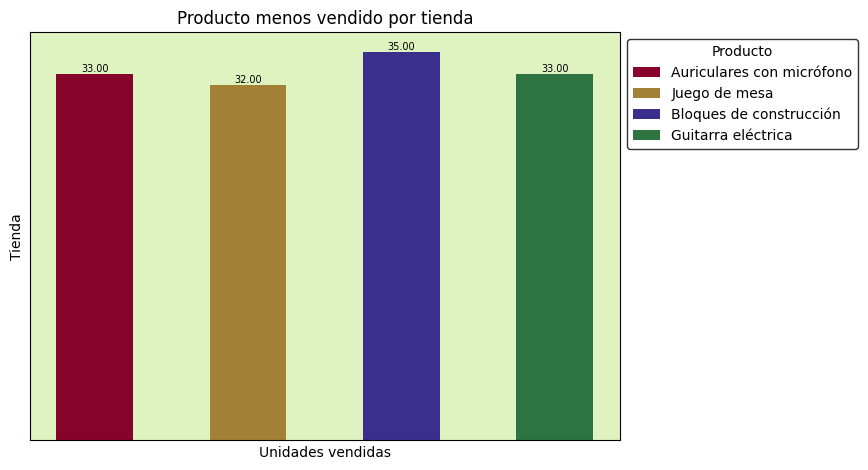

In [137]:
graf_prod_menos = grafico_barras(res_analsis_menos,'Producto', 'Cantidad Vendida', 'Unidades vendidas', 'Tienda', 'Producto menos vendido por tienda', 0.5, 'Producto')

### Coste de Envío Promedio para Cada Tienda:

El análisis del coste de envío promedio muestra variaciones entre las tiendas. La **Tienda 4** presenta el coste de envío promedio más bajo, lo que podría ser un factor atractivo para los clientes. Por otro lado, la **Tienda 1** tiene el coste promedio más alto, lo que podría influir negativamente en la decisión de compra de algunos clientes como se observa en la tabla 7 y la gráfica 7.

**Tabla 7. Costo de envió por tienda**

In [138]:
res_analisis_envio

,Tienda,Envío Promedio
0,1,26018.61
1,2,25216.24
2,3,24805.68
3,4,23459.46


**Gráfica 7. Costo de envió promedio por tienda**

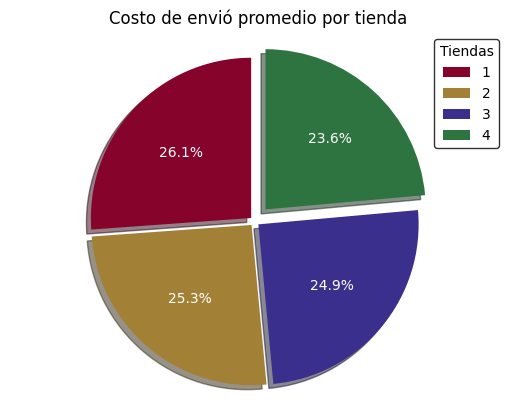

In [139]:
graf_env = grafico_torta(res_analisis_envio, 'Tienda', 'Envío Promedio', 'Costo de envió promedio por tienda', 'Tiendas' )

## Conclusión y Recomendación

Basándonos en el análisis integral de los datos y las visualizaciones generadas, se recomienda enfáticamente al Sr. Juan considerar la venta de la **Tienda 1**.

## Justificación de la Decisión:

La **Tienda 1** destaca significativamente por su mayor volumen de ingresos totales, lo que indica una sólida base de clientes y un alto potencial de rentabilidad. Si bien otras tiendas pueden tener fortalezas individuales, como calificaciones ligeramente superiores (en el caso de la **Tienda 3**) o costes de envío más bajos (en el caso de la **Tienda 4**), la **Tienda 1** demuestra un rendimiento general superior en el aspecto financiero, que suele ser un factor primordial en la decisión de venta de un negocio.

Además, su desempeño bueno en la categoría de productos más vendida sugiere una alineación con la demanda del mercado. Aunque se deben considerar las áreas de mejora identificadas, como optimizar el rendimiento de las categorías menos vendidas o aprender de las estrategias que generan altas calificaciones en otras tiendas, la solidez de sus ingresos la convierte en la opción más atractiva desde una perspectiva puramente económica.

En resumen, si bien cada tienda presenta sus propias características, la **Tienda 1** ofrece el perfil más robusto en términos de ingresos generados, lo que la posiciona como la opción más ventajosa para la venta por parte del Sr. Juan. Se recomienda al Sr. Juan profundizar en los detalles operativos y financieros específicos de esta tienda para tomar la decisión final, pero los datos analizados señalan claramente su potencial superior.